In [55]:
import sys
sys.path.insert(0, '../')
from utils.common import * 
from utils.common import generate_edges
from utils.GEIGP import GEIGP
from utils.AEIGP import AEIGP
from utils.AEIGPNU import AEIGPNU
from utils.POE import POE
from utils.GPOE import GPOE
from utils.BCM import BCM
from utils.RBCM import RBCM
from utils.DAC import DAC
from utils.MOE import MOE
import numpy as np
from numpy import genfromtxt
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import networkx as nx

# Graph & Data
---

## NOTE: To demonestrate the efficientiveness of EIGP approach, no specific random seed was set.
## Despite variations in the datasets simulated resulting in diverse evaluation outcomes, the conclusions remain consistent.

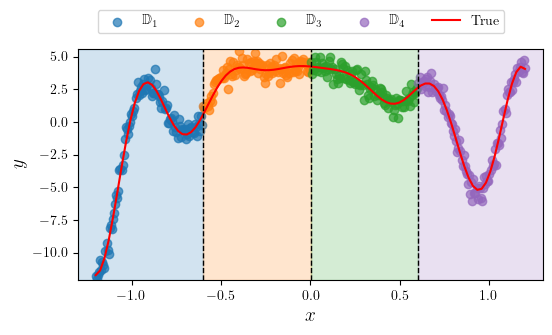

In [56]:
agentQuantity = 4
nodes = range(0, agentQuantity)
edges = generate_edges(agentQuantity)
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from((node, node) for node in nodes)
G.add_edges_from(edges)
A = nx.adjacency_matrix(G).todense()
# Generate data
n = 400
sn = 0.5
nt = 100

def true_function(x):
    return 5 * x**2 * np.sin(12*x) + (x**3 - 0.5) * np.sin(3*x - 0.5) + 4 * np.cos(2*x)

f = lambda x: true_function(x)
x = np.linspace(-1.2, 1.2, n)
y = f(x) + sn * np.random.randn(n)  # Training data

xt = np.linspace(-1.2, 1.2, nt)
yt = f(xt)   # Test data

x_all = x
y_all = y
x_test = xt
y_test= yt

# Divide the data into 4 subsets (quarters)
n = len(x_all)
quarter = n // 4


# Divide the data into 4 subsets (quarters)
Y_train_list = [y_all[i*quarter: (i+1)*quarter].reshape((1, -1)) for i in range(agentQuantity)]
X_train_list = [x_all[i*quarter: (i+1)*quarter].reshape((1, -1)) for i in range(agentQuantity)]
X_test = x_test.reshape((1, -1))
Y_test = y_test.reshape((1, -1))


x_min_lim  = x_all.min() - 0.1
x_max_lim  = x_all.max() + 0.1
y_min_lim  = y_all.min() - 0.1
y_max_lim  = y_all.max() + 0.1
# Set background colors for each quadrant
quadrant_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsfonts}')
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# Create a scatter plot with different colors for each subset and corresponding background color
fig, ax = plt.subplots(figsize=(6, 3))
# fig.suptitle('Data with Different Colors and Backgrounds for Subsets')

# Scatter plot for each subset
ax.scatter(x_all[:quarter], y_all[:quarter], label='Subset 1', color=quadrant_colors[0], alpha=0.7)
ax.scatter(x_all[quarter:2*quarter], y_all[quarter:2*quarter], label='Subset 2', color=quadrant_colors[1], alpha=0.7)
ax.scatter(x_all[2*quarter:3*quarter], y_all[2*quarter:3*quarter], label='Subset 3', color=quadrant_colors[2], alpha=0.7)
ax.scatter(x_all[3*quarter:], y_all[3*quarter:], label='Subset 4', color=quadrant_colors[3], alpha=0.7)

ax.plot(x_test, y_test, 'r-', label='Exact')

# Set background colors for each subset
ax.set_facecolor('none')  # Set the overall background color to none

# Set background colors for each quadrant
ax.axvline(x_all[quarter], color='black', linestyle='--', linewidth=1)  # Vertical line separating quadrant 1 and 2
ax.axvline(x_all[2*quarter], color='black', linestyle='--', linewidth=1)  # Vertical line separating quadrant 2 and 3
ax.axvline(x_all[3*quarter], color='black', linestyle='--', linewidth=1)  # Horizontal line separating quadrant 1 and 3

rect0 = Rectangle((x_min_lim, y_min_lim), 
                  np.abs(x_min_lim)+x_all[quarter], 
                  (y_max_lim - y_min_lim), color=quadrant_colors[0], alpha=0.2)
rect1 = Rectangle((x_all[quarter], y_min_lim), 
                  x_all[2*quarter]- x_all[quarter], 
                  (y_max_lim - y_min_lim), color=quadrant_colors[1], alpha=0.2)
rect2 = Rectangle((x_all[2*quarter], y_min_lim), 
                  x_all[3*quarter]- x_all[2*quarter], 
                  (y_max_lim - y_min_lim), color=quadrant_colors[2], alpha=0.2)
rect3 = Rectangle((x_all[3*quarter], y_min_lim), 
                  x_max_lim- x_all[3*quarter], 
                  (y_max_lim - y_min_lim), color=quadrant_colors[3], alpha=0.2)
ax.add_patch(rect0)
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)

ax.set_xlabel("$x$", fontsize=14)
ax.set_ylabel("$y$", fontsize=14)
# Set x and y limits
ax.set_xlim(x_min_lim, x_max_lim)
ax.set_ylim(y_min_lim, y_max_lim)
# Move the legend to the top outside the plot
legend_labels = ['$\displaystyle{\mathbb{D}_{1}}$',
                 '$\displaystyle{\mathbb{D}_{2}}$',
                  '$\displaystyle{\mathbb{D}_{3}}$',
                   '$\displaystyle{\mathbb{D}_{4}}$',
                    'True']
ax.legend(labels = legend_labels, loc='upper center', bbox_to_anchor=(0.48, 1.2), bbox_transform=ax.transAxes,fancybox=True, shadow=False, ncol=5)
# Show the plot
plt.show()

# Training
---

In [57]:
indivDataThersh = 100
x_dim = X_test.shape[0]
y_dim = Y_test.shape[0]
sigmaN = 1 * np.ones([y_dim, 1], dtype=float)
sigmaF = 1 * np.ones([y_dim, 1], dtype=float)
sigmaL = 0.1 * np.ones([x_dim, y_dim], dtype=float)
priorFunc = lambda x: np.zeros((y_dim,1))
priorFunc_lsit =[priorFunc for _ in range(agentQuantity)]

GEIGPR = GEIGP(x_dim, y_dim, indivDataThersh, 
              sigmaN, sigmaF, sigmaL, 
              priorFunc_lsit, agentQuantity, G)
GEIGPR.addDataEntire_agents(X_train_list, Y_train_list)
AEIGPR = AEIGP(x_dim, y_dim, indivDataThersh, 
              sigmaN, sigmaF, sigmaL, 
              priorFunc_lsit, agentQuantity, G)
AEIGPR.addDataEntire_agents(X_train_list, Y_train_list)
AEIGPRNU = AEIGPNU(x_dim, y_dim, indivDataThersh, 
              sigmaN, sigmaF, sigmaL, 
              priorFunc_lsit, agentQuantity, G)
AEIGPRNU.addDataEntire_agents(X_train_list, Y_train_list)
POEGPR= POE(x_dim, y_dim, indivDataThersh, 
              sigmaN, sigmaF, sigmaL, 
              priorFunc_lsit, agentQuantity, G)
POEGPR.addDataEntire_agents(X_train_list, Y_train_list)
GPOEGPR= GPOE(x_dim, y_dim, indivDataThersh, 
              sigmaN, sigmaF, sigmaL, 
              priorFunc_lsit, agentQuantity, G)
GPOEGPR.addDataEntire_agents(X_train_list, Y_train_list)
BCMGPR= BCM(x_dim, y_dim, indivDataThersh, 
              sigmaN, sigmaF, sigmaL, 
              priorFunc_lsit, agentQuantity, G)
BCMGPR.addDataEntire_agents(X_train_list, Y_train_list)
RBCMGPR= RBCM(x_dim, y_dim, indivDataThersh, 
              sigmaN, sigmaF, sigmaL, 
              priorFunc_lsit, agentQuantity, G)
RBCMGPR.addDataEntire_agents(X_train_list, Y_train_list)
DACGPR = DAC(x_dim, y_dim, indivDataThersh, 
              sigmaN, sigmaF, sigmaL, 
              priorFunc_lsit, agentQuantity, G)
DACGPR.addDataEntire_agents(X_train_list, Y_train_list)
MOEGPR = MOE(x_dim, y_dim, indivDataThersh, 
              sigmaN, sigmaF, sigmaL, 
              priorFunc_lsit, agentQuantity, G)
MOEGPR.addDataEntire_agents(X_train_list, Y_train_list)

mu_gEIGP_TestList = [[] for _ in range(agentQuantity)]
mu_aEIGP_TestList = [[] for _ in range(agentQuantity)]
mu_aEIGPnu1_TestList = [[] for _ in range(agentQuantity)]
mu_POE_TestList = [[] for _ in range(agentQuantity)]
mu_GPOE_TestList = [[] for _ in range(agentQuantity)]
mu_BCM_TestList = [[] for _ in range(agentQuantity)]
mu_RBCM_TestList = [[] for _ in range(agentQuantity)]
mu_DAC_TestList = [[] for _ in range(agentQuantity)]
mu_MOE_TestList = [[] for _ in range(agentQuantity)]
mu_IND_TestList = [[] for _ in range(agentQuantity)]

predictTime_gEIGP = [[] for _ in range(agentQuantity)]
predictTime_aEIGP = [[] for _ in range(agentQuantity)]
predictTime_aEIGPnu1 = [[] for _ in range(agentQuantity)]
predictTime_POE = [[] for _ in range(agentQuantity)]
predictTime_GPOE = [[] for _ in range(agentQuantity)]
predictTime_BCM = [[] for _ in range(agentQuantity)]
predictTime_RBCM = [[] for _ in range(agentQuantity)]
predictTime_DAC_IND = [[] for _ in range(agentQuantity)]
predictTime_DAC = []
predictTime_MOE = [[] for _ in range(agentQuantity)]
predictTime_IND = [[] for _ in range(agentQuantity)]
Pstates = np.zeros([2*y_dim*agentQuantity,1])
mu_sig = np.zeros([2*y_dim*agentQuantity,1])
ADCstate_dim = 2*y_dim

# Learning
---

In [58]:
for j_data in range(np.shape(X_test)[1]):
    x = X_test[:, j_data].reshape((x_dim, 1))
    y = Y_test[:, j_data]
    for i_agent in range(agentQuantity):
        # gEIGP
        start_time = time.time()
        mu_gEIGP = GEIGPR.predict_gEIGP(i_agent, x)
        end_time = time.time()
        predictTime_gEIGP[i_agent].append(end_time - start_time)
        mu_gEIGP_TestList[i_agent].append(mu_gEIGP)
        # aEIGP
        start_time = time.time()
        mu_aEIGP, var_aEIGP = AEIGPR.predict_aEIGP(i_agent,x)
        end_time = time.time()
        predictTime_aEIGP[i_agent].append(end_time - start_time)
        mu_aEIGP_TestList[i_agent].append(mu_aEIGP)
        # aEIGPnu1
        start_time = time.time()
        mu_aEIGPnu1 = AEIGPRNU.predict_mu_aEIGP(i_agent,x)
        end_time = time.time()
        predictTime_aEIGPnu1[i_agent].append(end_time - start_time)
        mu_aEIGPnu1_TestList[i_agent].append(mu_aEIGPnu1)

        # POE
        start_time = time.time()
        mu_POE, var_POE = POEGPR.predict_POE(i_agent, x)
        end_time = time.time()
        predictTime_POE[i_agent].append(end_time - start_time)
        mu_POE_TestList[i_agent].append(mu_POE)
        # GPOE
        start_time = time.time()
        mu_GPOE, var_GPOE = GPOEGPR.predict_GPOE(i_agent, x)
        end_time = time.time()
        predictTime_GPOE[i_agent].append(end_time - start_time)
        mu_GPOE_TestList[i_agent].append(mu_GPOE)
        # BCM
        start_time = time.time()
        mu_BCM, var_BCM = BCMGPR.predict_BCM(i_agent,x)
        end_time = time.time()
        predictTime_BCM[i_agent].append(end_time - start_time)
        mu_BCM_TestList[i_agent].append(mu_BCM)
        # RBCM
        start_time = time.time()
        mu_RBCM, var_RBCM = RBCMGPR.predict_RBCM(i_agent,x)
        end_time = time.time()
        predictTime_RBCM[i_agent].append(end_time - start_time)
        mu_RBCM_TestList[i_agent].append(mu_RBCM)
        # DAC_IND
        start_time = time.time()
        mu_DAC_IND, var_DAC_IND = DACGPR.predict_DAC_IND(i_agent,x)
        end_time = time.time()
        predictTime_DAC_IND[i_agent].append(end_time - start_time)
        mu_sig[i_agent*2*y_dim]= np.squeeze(mu_DAC_IND/var_DAC_IND)
        mu_sig[i_agent*2*y_dim+1]= np.squeeze(1/var_DAC_IND)
        # MOE
        start_time = time.time()
        mu_MOE = MOEGPR.predict_MOE(i_agent, x)
        end_time = time.time()
        predictTime_MOE[i_agent].append(end_time - start_time)
        mu_MOE_TestList[i_agent].append(mu_MOE)
 

    start_time = time.time()
    p0 = Pstates.ravel()
    mu_DAC_MAS, Pstates = DACGPR.predict_DAC(p0, mu_sig, A)
    end_time = time.time()
    predictTime_DAC.append(end_time - start_time)
    [mu_DAC_TestList[i_agent].append(mu_DAC_MAS[i_agent][0]) for i_agent in range(agentQuantity)]


In [59]:
errors_gEIGP_TestList = np.absolute(Y_test- mu_gEIGP_TestList)
errors_aEIGP_TestList = np.absolute(Y_test- mu_aEIGP_TestList)
errors_aEIGPnu1_TestList = np.absolute(Y_test- mu_aEIGPnu1_TestList)
errors_POE_TestList = np.absolute(Y_test- mu_POE_TestList)
errors_GPOE_TestList = np.absolute(Y_test- mu_GPOE_TestList)
errors_BCM_TestList = np.absolute(Y_test- mu_BCM_TestList)
errors_RBCM_TestList = np.absolute(Y_test- mu_RBCM_TestList)
errors_DAC_TestList = np.absolute(Y_test- mu_DAC_TestList)
errors_MOE_TestList = np.absolute(Y_test- mu_MOE_TestList)
# Initialize the result array with the first array
errors_gEIGP_Test = np.zeros([np.shape(Y_test)[1],])
errors_aEIGP_Test = np.zeros([np.shape(Y_test)[1],])
errors_aEIGPnu1_Test = np.zeros([np.shape(Y_test)[1],])
errors_POE_Test = np.zeros([np.shape(Y_test)[1],])
errors_GPOE_Test = np.zeros([np.shape(Y_test)[1],])
errors_BCM_Test = np.zeros([np.shape(Y_test)[1],])
errors_RBCM_Test = np.zeros([np.shape(Y_test)[1],])
errors_DAC_Test = np.zeros([np.shape(Y_test)[1],])
errors_MOE_Test = np.zeros([np.shape(Y_test)[1],])

for i in range(4):
    errors_gEIGP_Test += errors_gEIGP_TestList[i]
    errors_aEIGP_Test += errors_aEIGP_TestList[i]
    errors_aEIGPnu1_Test += errors_aEIGPnu1_TestList[i]
    errors_POE_Test += errors_POE_TestList[i]
    errors_GPOE_Test += errors_GPOE_TestList[i]
    errors_BCM_Test += errors_BCM_TestList[i]
    errors_RBCM_Test += errors_RBCM_TestList[i]
    errors_DAC_Test += errors_DAC_TestList[i]
    errors_MOE_Test += errors_MOE_TestList[i]


smse_gEIGP = np.cumsum((errors_gEIGP_Test/4) ** 2) / np.arange(1, len(errors_gEIGP_Test) + 1) / np.var(Y_test[0,:])
smse_aEIGP = np.cumsum((errors_aEIGP_Test/4) ** 2) / np.arange(1, len(errors_aEIGP_Test) + 1) / np.var(Y_test[0,:])
smse_aEIGPnu1 = np.cumsum((errors_aEIGPnu1_Test/4) ** 2) / np.arange(1, len(errors_aEIGPnu1_Test) + 1) / np.var(Y_test[0,:])
smse_POE = np.cumsum((errors_POE_Test/4) ** 2) / np.arange(1, len(errors_POE_Test) + 1) / np.var(Y_test[0,:])
smse_GPOE = np.cumsum((errors_GPOE_Test/4) ** 2) / np.arange(1, len(errors_GPOE_Test) + 1) / np.var(Y_test[0,:])
smse_BCM = np.cumsum((errors_BCM_Test/4) ** 2) / np.arange(1, len(errors_BCM_Test) + 1) / np.var(Y_test[0,:])
smse_RBCM = np.cumsum((errors_RBCM_Test/4) ** 2) / np.arange(1, len(errors_RBCM_Test) + 1) / np.var(Y_test[0,:])
smse_DAC = np.cumsum((errors_DAC_Test/4) ** 2) / np.arange(1, len(errors_DAC_Test) + 1) / np.var(Y_test[0,:])
smse_MOE = np.cumsum((errors_MOE_Test/4) ** 2) / np.arange(1, len(errors_MOE_Test) + 1) / np.var(Y_test[0,:])


/var/folders/d6/4ww_t_md77b57vhv75x05wsw0000gn/T/ipykernel_87464/1340032208.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


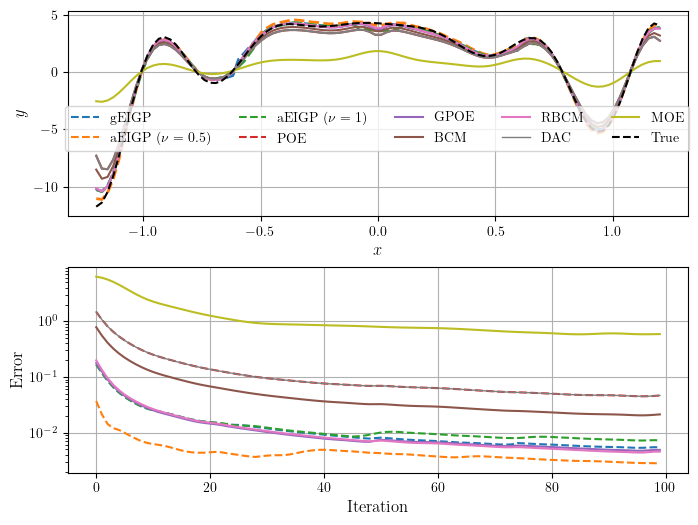

In [60]:
fig_1, axes = plt.subplots(2, 1, figsize=(8, 6))
fig_1.subplots_adjust(hspace=0.25,)
# fig_1.suptitle('Error Comparison for Different Methods')
# gs = fig_1.add_gridspec(2, 1, height_ratios=[2, 1])

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsfonts}')
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rcParams.update({'font.size': 10}) 
method_colors = plt.cm.tab10.colors
legend_labels = ['gEIGP', 'aEIGP ($\\nu = 0.5$)', 'aEIGP ($\\nu = 1$)', 'POE', 'GPOE', 'BCM', 'RBCM', 'DAC', 'MOE', 'True']
axes[0].plot(X_test.ravel(),mu_gEIGP_TestList[i_agent], color = method_colors[0], linestyle='--', linewidth = 2)
axes[0].plot(X_test.ravel(),mu_aEIGP_TestList[i_agent], color = method_colors[1], linestyle='--', linewidth = 2)
axes[0].plot(X_test.ravel(),mu_aEIGPnu1_TestList[i_agent], color = method_colors[2], linestyle='--', linewidth = 2)
axes[0].plot(X_test.ravel(),mu_POE_TestList[i_agent], color = method_colors[3])
axes[0].plot(X_test.ravel(),mu_GPOE_TestList[i_agent], color = method_colors[4])
axes[0].plot(X_test.ravel(),mu_BCM_TestList[i_agent], color = method_colors[5])
axes[0].plot(X_test.ravel(),mu_RBCM_TestList[i_agent], color = method_colors[6])
axes[0].plot(X_test.ravel(),mu_DAC_TestList[i_agent], color = method_colors[7])
axes[0].plot(X_test.ravel(),mu_MOE_TestList[i_agent], color = method_colors[8])
axes[0].plot(X_test.ravel(),Y_test.transpose(), color = 'k',  linestyle='--')
axes[0].set_xlabel('$x$', fontsize=12)
axes[0].set_ylabel('$y$', fontsize=12)
axes[0].yaxis.grid(True)
axes[0].xaxis.grid(True)

axes[1].plot(smse_gEIGP, color = method_colors[0], linestyle='--')
axes[1].plot(smse_aEIGP, color = method_colors[1], linestyle='--')
axes[1].plot(smse_aEIGPnu1,  color = method_colors[2], linestyle='--')
axes[1].plot(smse_POE, color = method_colors[3], linestyle='--')
axes[1].plot(smse_GPOE, color = method_colors[4])
axes[1].plot(smse_BCM,  color = method_colors[5],)
axes[1].plot(smse_RBCM, color = method_colors[6],)
axes[1].plot(smse_DAC, color = method_colors[7],linewidth = 1)
axes[1].plot(smse_MOE, color = method_colors[8],)
axes[1].plot(np.zeros([np.shape(Y_test)[1],]), color = 'k',  linestyle='--')

# axes_1.set_title(f'MAS')
axes[1].set_xlabel('Iteration', fontsize=12)
axes[1].set_ylabel('Error', fontsize=12)
axes[1].set_yscale('log') 
axes[1].legend()
axes[1].yaxis.grid(True)
axes[1].xaxis.grid(True)

plt.legend(labels = legend_labels, loc='upper center', bbox_to_anchor=(0.65, 1.7), 
           bbox_transform=ax.transAxes,fancybox=True, shadow=False, ncol=5)

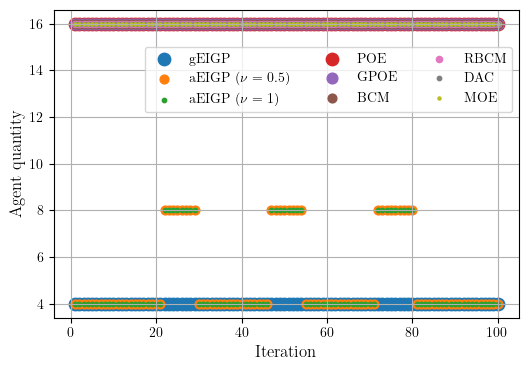

In [61]:
agentNumber_gEIGP = [sum(x) for x in zip(*GEIGPR.requestNeighborQuantity_list)]
agentNumber = [sum(x) for x in zip(*AEIGPR.requestNeighborQuantity_list)]
agentNumber_aEIGPnu1 = [sum(x) for x in zip(*AEIGPRNU.requestNeighborQuantity_list)]

fig_10, axes_10 = plt.subplots(1, 1, figsize=(6, 4))

axes_10.scatter(range(1, len(agentNumber) + 1), agentNumber_gEIGP, label='gEIGP', color = method_colors[0], s=80)
axes_10.scatter(range(1, len(agentNumber) + 1), agentNumber, label='aEIGP ($\\nu=0.5$)', color = method_colors[1], s=40)
axes_10.scatter(range(1, len(agentNumber) + 1), agentNumber_aEIGPnu1, label='aEIGP ($\\nu=1$)', color = method_colors[2], s=10)
axes_10.scatter(range(1, len(agentNumber) + 1),[16] * len(agentNumber), label='POE', color = method_colors[3], s=80)
axes_10.scatter(range(1, len(agentNumber) + 1),[16] * len(agentNumber), label='GPOE', color = method_colors[4], s=60)
axes_10.scatter(range(1, len(agentNumber) + 1),[16] * len(agentNumber), label='BCM', color = method_colors[5], s=40)
axes_10.scatter(range(1, len(agentNumber) + 1),[16] * len(agentNumber), label='RBCM', color = method_colors[6], s=20)
axes_10.scatter(range(1, len(agentNumber) + 1),[16] * len(agentNumber), label='DAC', color = method_colors[7], s=10)
axes_10.scatter(range(1, len(agentNumber) + 1),[16] * len(agentNumber), label='MOE', color = method_colors[8], s=5)

# axes_1.set_title(f'MAS')
axes_10.set_xlabel('Iteration', fontsize=12)
axes_10.set_ylabel('Agent quantity', fontsize=12)
axes_10.legend()
axes_10.yaxis.grid(True)
axes_10.xaxis.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.59, 0.9), ncol=3, fancybox=True, shadow=False)
# Show the plot
plt.show()
